### SIMPLE CNN Implementation

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_sample_image

In [3]:
china  = load_sample_image("china.jpg")/255
flower  = load_sample_image("flower.jpg")/255

In [4]:
image = np.array([china,flower])
batch_size, height,width,channels = image.shape

In [5]:
# Create 2 Filter 

In [6]:
filters = np.zeros(shape=(7,7,channels,2),dtype=np.float32)
filters[:,3,:,0]=1 #vertical line 
filters[3,:,:,1] =1 # horizontal Line  

In [7]:
output = tf.nn.conv2d(image,filters,strides=1,padding="SAME")

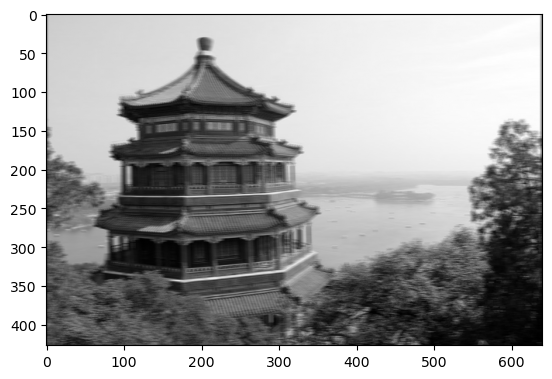

In [8]:
plt.imshow(output[0,:,:,1],cmap="gray") # plot 1st image's  , 2nd feature map
plt.show()

## Pooling Layers 

In [9]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)


In [10]:
output=max_pool(image)

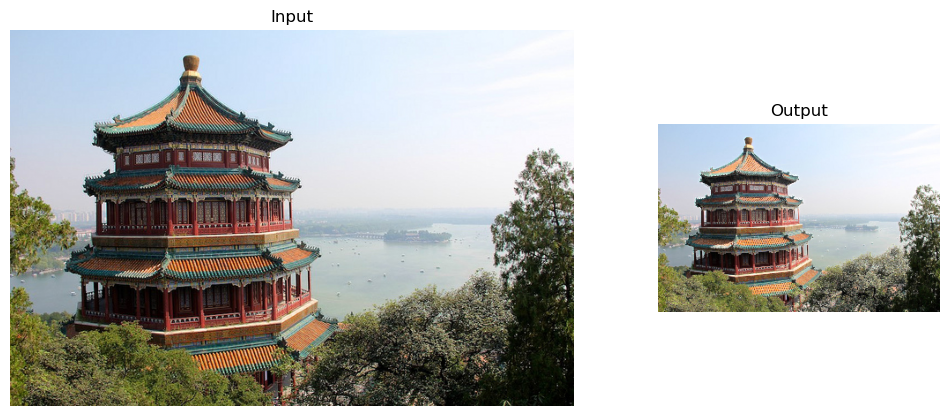

In [11]:
# extra code – this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(image[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### Depth-wise pooling 

In [12]:
np.random.seed(42)
fmaps = np.random.rand(2,70,120,60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps,ksize=(1,1,1,3),strides=(1,1,1,3),padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [13]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [14]:
# extra code – shows that this custom layer gives the same result as max_pool()
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

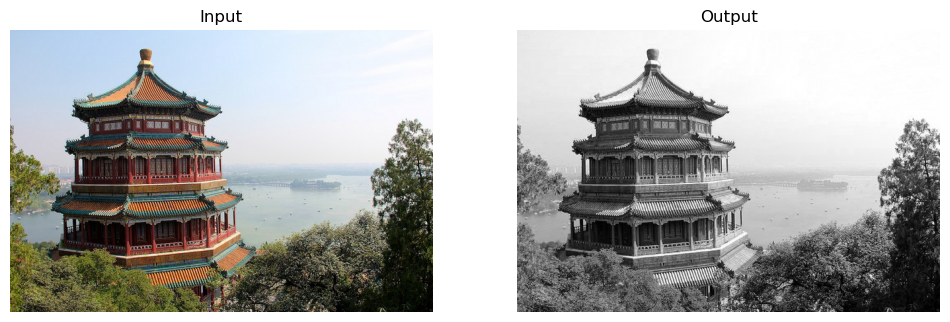

In [15]:
# extra code – computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(image)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(image[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()


GLobal Average Pooling 


In [16]:
global_avg_pool= tf.keras.layers.GlobalAveragePooling2D()


In [17]:
# The following layer is equivalent 
global_avg_pool = tf.keras.layers.Lambda(
    lambda X:tf.reduce_mean(X,axis=[1,2])
)

In [18]:
global_avg_pool(image)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.56767327, 0.5706355 , 0.5528319 ],
       [0.21627817, 0.28856644, 0.2232219 ]], dtype=float32)>

### CNN Architectures

In [19]:
# load the MNist fashion datasets 
mnist = tf.keras.datasets.fashion_mnist.load_data()

In [20]:
(X_train_full , y_train_full),(X_test,y_test) = mnist

# This is the common preprocessing method of Deep Learning  when working  with grayscale data like mnist  ,mnist-fashion  
X_train_full = np.expand_dims(X_train_full,axis=-1).astype(np.float32)/255 # used the np.expand_dims for adding extra dims at the end of array 
#because before adding the dims at end array looks like (60000,28,28) so tensorflow required the input_format in (batch_size , channels , height, width) 
# thus we need to change it and add '1' at end of the array 
y_train_full = np.expand_dims(y_train_full,axis=-1).astype(np.float32)/255

In [21]:
X_train ,X_valid = X_train_full[:-5000],X_train_full[-5000:]
y_train,y_valid = y_train_full[:-5000],y_train_full[-5000:]

In [22]:
from functools import partial
tf.random.set_seed(42)
DefaultConv2D  = partial (tf.keras.layers.Conv2D,kernel_size=3,padding="same",
                          activation="relu",kernel_initializer = "he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64,kernel_size=7,input_shape=[28,28,1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(), # reshape the data in 1D vector ,it doesn't change data  
    tf.keras.layers.Dense(units=128,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10,activation="softmax")
    
])

/opt/anaconda3/envs/DSenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# extra code for compile and run the model training
model.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])
history= model.fit(X_train,y_train,epochs=10,
                   validation_data=(X_valid,y_valid))
score = model.evaluate(X_test,y_test)
X_new = X_test[:10] #pretend we have new images 
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 164s 95ms/step - accuracy: 0.0976 - loss: 0.0381 - val_accuracy: 0.1042 - val_loss: 0.0000e+00
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 188s 109ms/step - accuracy: 0.0984 - loss: 2.1483e-04 - val_accuracy: 0.1042 - val_loss: 0.0000e+00
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 187s 109ms/step - accuracy: 0.0984 - loss: 9.6154e-04 - val_accuracy: 0.1042 - val_loss: 0.0000e+00
Epoch 4/10
 262/1719 ━━━━━━━━━━━━━━━━━━━━ 2:33 106ms/step - accuracy: 0.0964 - loss: 0.0000e+00

KeyboardInterrupt: 

### LeNe-5 Architecture Implemetation 



#### mostly used for MNIST Datasets , it use for handwritten character detection 

In [27]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation="tanh", input_shape=(32, 32, 1)),
    tf.keras.layers.AveragePooling2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation="tanh"),
    tf.keras.layers.AveragePooling2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=120, kernel_size=5, activation="tanh"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(84, activation="tanh"),
    tf.keras.layers.Dense(10, activation="softmax")
])


/opt/anaconda3/envs/DSenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### AlexNet Architecture Implementation


#### Where AlexNet is/was mostly used:

* Large-scale image classification tasks (like ImageNet — 1 million+ images, 1000 classes)
* Feature extraction: use pretrained AlexNet layers to extract features and feed them into other models (called transfer learning).
* Object detection: early versions of detection models (like RCNN) used AlexNet as the backbone feature extractor.
* Medical imaging: classification tasks where large datasets are available.
* Research and education: it’s often used to teach CNN basics because it’s simple yet powerful.

In [28]:
import tensorflow as tf

model = tf.keras.Sequential([
    # 1st Convolutional Layer
    tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu', input_shape=(227, 227, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    # 2nd Convolutional Layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    # 3rd Convolutional Layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding="same", activation='relu'),

    # 4th Convolutional Layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding="same", activation='relu'),

    # 5th Convolutional Layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    tf.keras.layers.Flatten(),

    # 1st Fully Connected Layer
    tf.keras.layers.Dense(units=4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # 2nd Fully Connected Layer
    tf.keras.layers.Dense(units=4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Output Layer
    tf.keras.layers.Dense(units=1000, activation='softmax')
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,378,344 (237.95 MB)

 Trainable params: 62,378,344 (237.95 MB)

 Non-trainable params: 0 (0.00 B)